In [16]:
#this model uses sgd optimizer and leakyrelu activation function

In [17]:
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

from sklearn.model_selection import train_test_split
import tensorflow as tf

from tensorflow_addons.optimizers import Lookahead , RectifiedAdam
from keras.callbacks import EarlyStopping
from keras.metrics import Recall, Precision
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, Input, BatchNormalization, Activation,UpSampling2D
from keras.models import Model
from PIL import Image
import random

In [18]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)


smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    
    intersection = tf.reduce_sum(y_true*y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))


def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [19]:
h = 256
w = 256
batch_size = 8
learning_rate = 0.0001

epochs = 15

In [20]:
def load_data(data_path , split = 0.2):
    images = sorted(glob(data_path + '/*sat.jpg'))
    masks = sorted(glob(data_path + '/*mask.png'))
    size = int(len(images) * split)
    
    train_x, val_x = train_test_split(images, test_size=0.2 , random_state=42)
    train_y, val_y = train_test_split(masks, test_size= 0.2, random_state= 42)
    
    train_x, test_x = train_test_split(train_x, test_size= 0.2, random_state=42 )
    train_y , test_y = train_test_split(train_y, test_size=0.2, random_state=42)
    
    return (train_x, train_y), (val_x, val_y), (test_x, test_y)

In [21]:
data_path = 'train'
(x_train, y_train), (x_val, y_val), (x_test, y_test)= load_data(data_path)

In [22]:
len(x_train), len(y_train), len(x_val), len(y_val), len(x_test), len(y_test)

(3984, 3984, 1246, 1246, 996, 996)

In [23]:
def read_image(path):
    try :
        img = Image.open(path)
        img = img.resize((w,h))
        x = np.array(img, dtype=np.float32)
        x = x / 255.0
        return x
    except Exception as e: 
        print(f'Error while reading image :{e}')
        return None
    
    
def read_mask(path):
    try:
        mask = Image.open(path).convert('L')
        mask = mask.resize((w,h))
        x = np.array(mask, dtype=np.float32)
        x = x / 255.0
        x = np.expand_dims(x, axis=-1)
        return x
    except Exception as e: 
        print(f'Error while reading image :{e}')
        return None
    
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y
    
    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([h, w, 3])
    y.set_shape([h, w, 1])
    return x, y


def tf_dataset(X, Y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    
    return dataset

In [24]:
def random_sample ():
    random_inx = random.randint(0 , len(x_train)-1)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(read_image(x_train[random_inx]))
    plt.title('Image')
    
    plt.subplot(1, 2, 2)
    plt.imshow(read_image(y_train[random_inx]))
    plt.title('Mask')
    
    plt.show()

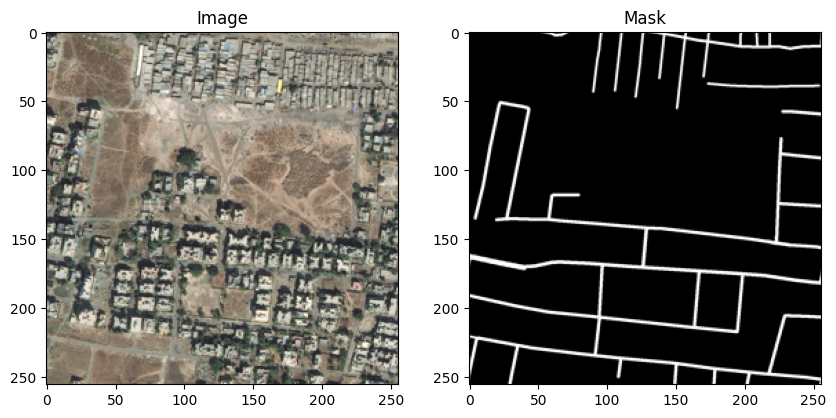

In [25]:
random_sample()

In [26]:
train_dataset = tf_dataset(x_train, y_train, batch=batch_size)
val_dataset = tf_dataset(x_val, y_val, batch=batch_size)

train_steps = (len(x_train) // batch_size)
val_steps = (len(x_val) // batch_size)

print('train_steps = ', train_steps)
print('val_steps = ', val_steps)

train_steps =  498
val_steps =  155


In [27]:
# defining Conv2d block for our u-net
# this block essentially performs 2 convolution

def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                                kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('silu')(x)
    
    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                                kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('silu')(x)
    
    return x



# Now defining Unet 
def unet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    
    inputs = Input(shape= inputImage)
    
    c1 = Conv2dBlock(inputs , numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = inputs, outputs = [output])
    return model




In [28]:
input_shape = (h, w, 3)
inputs = input_shape

unet = unet(inputs, droupouts= 0.05)
unet.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

In [29]:

'''base_optimizer = RectifiedAdam(learning_rate=learning_rate)
lookahead_optimizer = Lookahead(base_optimizer, sync_period=5)

model.compile(optimizer=lookahead_optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])

model.summary()

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10,         # تعداد epoch‌هایی که صبر می‌کند قبل از توقف
    restore_best_weights=True ) # بازگرداندن بهترین وزن‌ها پس از توقف'''

"base_optimizer = RectifiedAdam(learning_rate=learning_rate)\nlookahead_optimizer = Lookahead(base_optimizer, sync_period=5)\n\nmodel.compile(optimizer=lookahead_optimizer,\n                loss='binary_crossentropy',\n                metrics=['accuracy'])\n\nmodel.summary()\n\nearly_stopping = EarlyStopping(\n    monitor='val_loss', \n    patience=10,         # تعداد epoch\u200cهایی که صبر می\u200cکند قبل از توقف\n    restore_best_weights=True ) # بازگرداندن بهترین وزن\u200cها پس از توقف"

In [30]:
history = unet.fit(train_dataset,
                    epochs=epochs,
                    validation_data=val_dataset,
                    steps_per_epoch=train_steps,
                    validation_steps=val_steps)

Epoch 1/15
498/498 [==============================] - 119s 234ms/step - loss: 0.2943 - accuracy: 0.9148 - val_loss: 0.1572 - val_accuracy: 0.9376
Epoch 2/15
498/498 [==============================] - 116s 233ms/step - loss: 0.1280 - accuracy: 0.9410 - val_loss: 0.1214 - val_accuracy: 0.9397
Epoch 3/15
498/498 [==============================] - 118s 235ms/step - loss: 0.1052 - accuracy: 0.9437 - val_loss: 0.1090 - val_accuracy: 0.9420
Epoch 4/15
498/498 [==============================] - 116s 233ms/step - loss: 0.0945 - accuracy: 0.9456 - val_loss: 0.1151 - val_accuracy: 0.9413
Epoch 5/15
498/498 [==============================] - 113s 227ms/step - loss: 0.0875 - accuracy: 0.9471 - val_loss: 0.1018 - val_accuracy: 0.9433
Epoch 6/15
498/498 [==============================] - 116s 232ms/step - loss: 0.0831 - accuracy: 0.9482 - val_loss: 0.0933 - val_accuracy: 0.9449
Epoch 7/15
498/498 [==============================] - 115s 230ms/step - loss: 0.0796 - accuracy: 0.9490 - val_loss: 0.0865 -

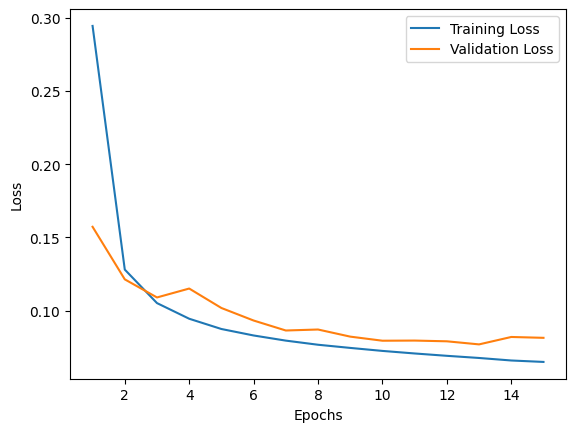

In [37]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Create a range of epochs for the x-axis
epochs = range(1, len(training_loss) + 1)

# Plot the loss curves
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 17ms/step


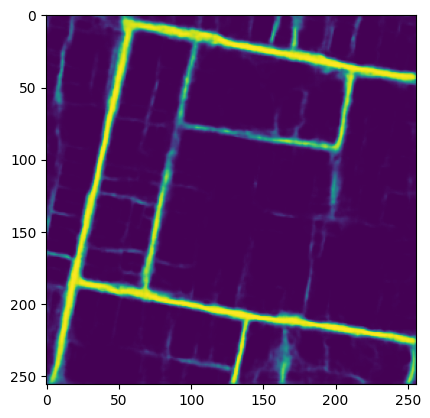

In [38]:
img =read_image("test/2704_sat.jpg")
img = np.expand_dims(img, axis=0)
pred = unet.predict(img)
plt.imshow(pred[0,...]) 

In [33]:
import cv2
import os

In [39]:
# مسیر فولدر حاوی تصاویر
folder_path = "test"

# لیست تمامی فایل‌های موجود در فولدر
all_files = os.listdir(folder_path)

# انتخاب تصادفی 10 فایل از لیست
selected_files = random.sample(all_files, 10)

# ذخیره نام فایل‌های انتخاب‌شده در یک لیست
file_names_list = [file_name for file_name in selected_files]

# چاپ لیست فایل‌ها
print("Selected files:", file_names_list)

file_names_with_prefix = ["test/" + name for name in file_names_list]
print("Selected files:", file_names_with_prefix)

Selected files: ['287031_sat.jpg', '516399_sat.jpg', '987728_sat.jpg', '523251_sat.jpg', '71163_sat.jpg', '741856_sat.jpg', '830751_sat.jpg', '81878_sat.jpg', '81562_sat.jpg', '907397_sat.jpg']
Selected files: ['test/287031_sat.jpg', 'test/516399_sat.jpg', 'test/987728_sat.jpg', 'test/523251_sat.jpg', 'test/71163_sat.jpg', 'test/741856_sat.jpg', 'test/830751_sat.jpg', 'test/81878_sat.jpg', 'test/81562_sat.jpg', 'test/907397_sat.jpg']


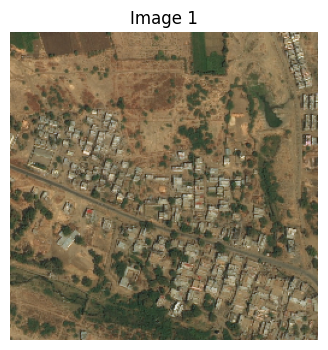

1/1 [==============================] - 0s 17ms/step


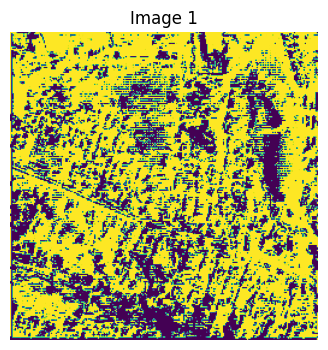

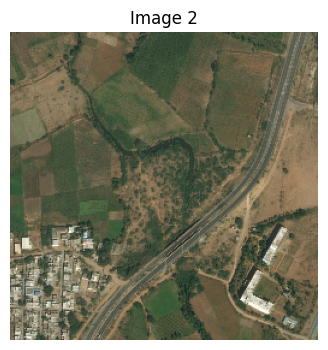

1/1 [==============================] - 0s 20ms/step


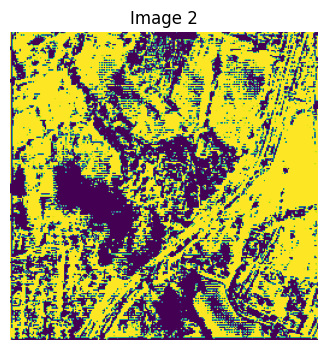

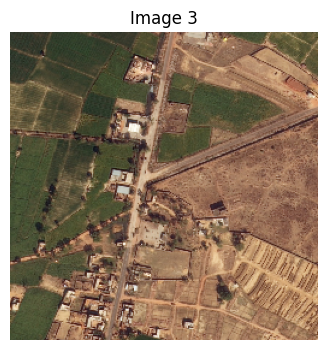

1/1 [==============================] - 0s 7ms/step


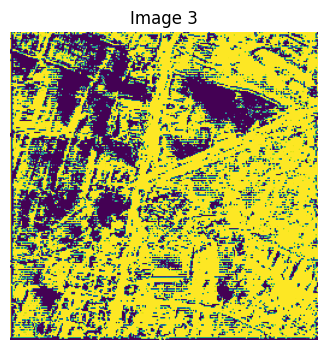

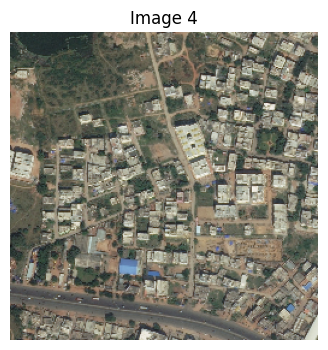

1/1 [==============================] - 0s 25ms/step


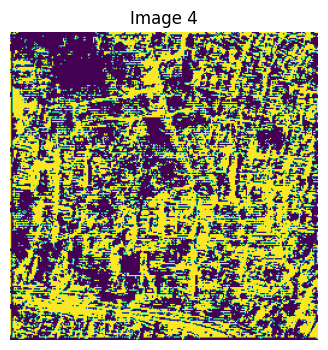

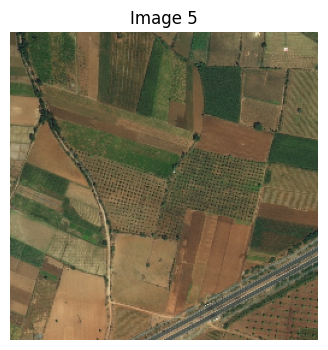

1/1 [==============================] - 0s 32ms/step


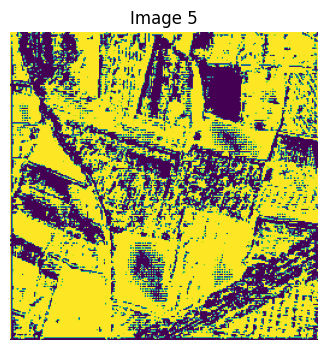

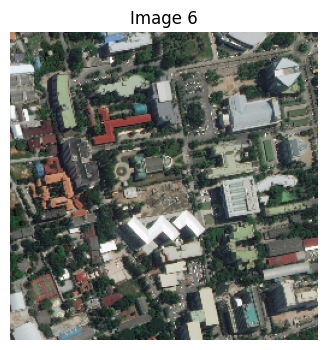

1/1 [==============================] - 0s 26ms/step


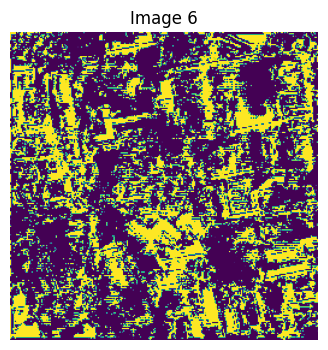

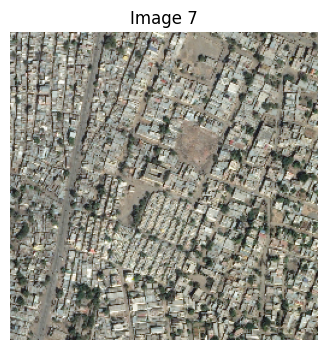

1/1 [==============================] - 0s 20ms/step


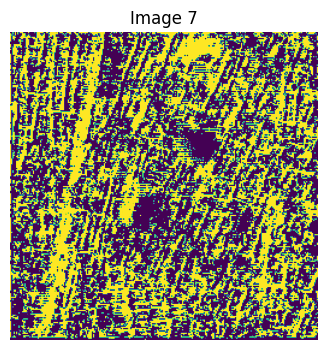

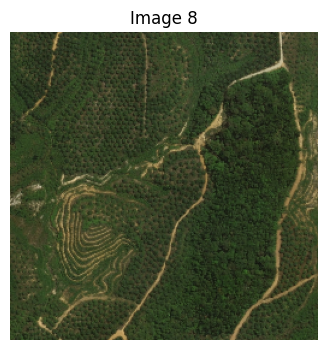

1/1 [==============================] - 0s 31ms/step


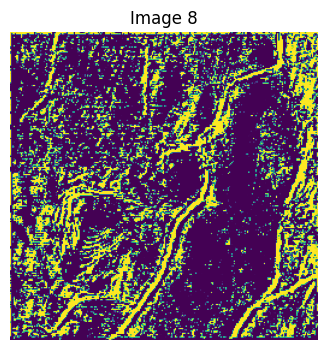

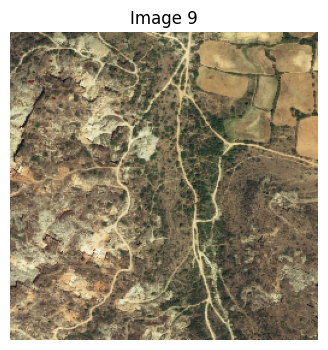

1/1 [==============================] - 0s 44ms/step


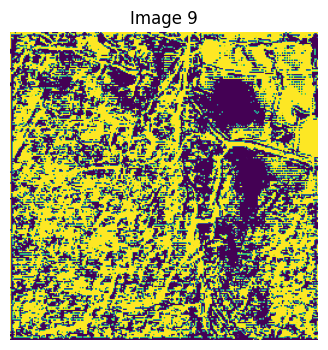

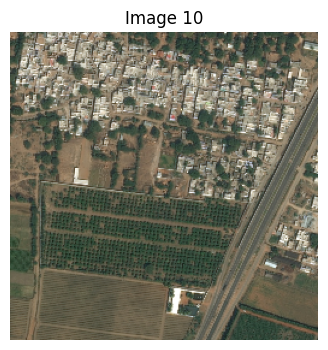

1/1 [==============================] - 0s 22ms/step


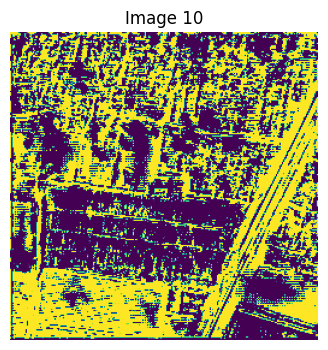

In [40]:
# نمایش تصاویر
for i, file_name in enumerate(file_names_with_prefix):
    # خواندن تصویر
    img = plt.imread(file_name)  # خواندن تصویر با OpenCV
    img = cv2.resize(img, (256, 256))
    if img is None:
        print(f"Cannot load image: {file_name}")
        continue

    
    # نمایش تصویر
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(f"Image {i + 1}")
    plt.axis("off")
    plt.show()
    
    
    img2 = np.expand_dims(img, axis=0)
    pred = unet.predict(img2)
    
    if pred is None:
        print(f"Cannot load image: {file_name}")
        continue

    # تبدیل تصویر از BGR به RGB
    

    # نمایش تصویر
    plt.figure(figsize=(4, 4))
    plt.imshow(pred[0,...])
    plt.title(f"Image {i + 1}")
    plt.axis("off")
    plt.show()

In [36]:
model.save('my_code_unet2.h5')

NameError: name 'model' is not defined